# Recurrent Neural network for time series

## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

%matplotlib inline

In [5]:
milk_df = pd.read_csv("./monthly-milk-production.csv", index_col='Month')

In [6]:
milk_df.head(3)

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0


#### Make the index a time series:

In [7]:
milk_df.index = pd.to_datetime(milk_df.index)

** Plot out the time series data. **

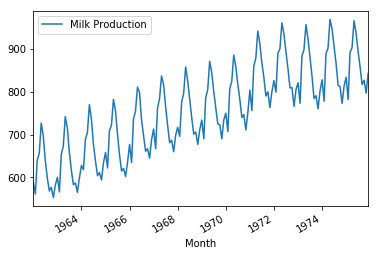

In [8]:
milk_df.plot()

___

### Split data

We want to predict a year's worth of data. (12 months or 12 steps into the future) **

In [9]:
milk_train = milk_df.head(156)
milk_test = milk_df.tail(12)

### Scale the Data


In [10]:
scaler = MinMaxScaler()

In [11]:
# We only want to fit to our training data since we are only using test to evaluate our model
scaler.fit(milk_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
milk_train = scaler.transform(milk_train)
milk_test = scaler.transform(milk_test)

In [16]:
len(milk_train)

156

## Batch Function

In [20]:
# this function returns a batch from our training data
# Each example in our batch will be a series of length steps
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # we generate a random starting index for our next batch
    start_point = np.random.randint(0, len(training_data)-steps)
    
    # get time series at index start_point, our series will have length steps
    y = np.array(training_data[start_point: start_point+steps+1])
    # change shape of batch from [steps+1, 1] to [1, steps+1]
    y = y.reshape([1, steps+1])
    
    # return next batch, first return value is our training example, second value is the label
    # we need to reshape our batch so that it matches the placeholder in our tensorflow graph
    return y[:,:-1].reshape(-1, steps,1), y[:,1:].reshape(-1,steps,1)

## TF Graph

### Hyperparameters

In [21]:
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
steps = 6000
batch_size=1

### Placeholders 

In [22]:
with tf.name_scope("Inputs"):
    X = tf.placeholder(tf.float32,shape=[None,num_time_steps-1,num_inputs])
    y = tf.placeholder(tf.float32,shape=[None, num_time_steps-1,num_outputs])

### RNN layer

In [23]:
with tf.name_scope("layer"):
    cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(
        num_units=num_neurons,activation=tf.nn.relu),output_size=num_outputs)
    outputs, states = tf.nn.dynamic_rnn(cell, X,dtype=tf.float32)

### Loss Function and Optimizer

In [24]:
# Mean squared loss
with tf.name_scope("Loss"):
    loss = tf.reduce_mean(tf.square(outputs-y))

with tf.name_scope("Optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(loss)

In [25]:
init = tf.global_variables_initializer()

In [27]:
saver = tf.train.Saver()

# Training

In [28]:
len(milk_train)
steps

6000

In [30]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(steps):
        
        x,y_batch = next_batch(milk_train,batch_size,num_time_steps-1)
        
        if i % (steps/10) == 0:
            print("step: {} MSE: {}".format(i, sess.run(loss,feed_dict={X:x, y:y_batch})))
            
        sess.run(train,feed_dict={X:x, y:y_batch})
    
    # Save Model for Later
    saver.save(sess, ".models/time_series_model.ckpt")
    print("Finished training")

step: 0 MSE: 0.6225711703300476
step: 600 MSE: 0.012590094469487667
step: 1200 MSE: 0.006848393008112907
step: 1800 MSE: 0.011672858148813248
step: 2400 MSE: 0.010241922922432423
step: 3000 MSE: 0.01331624761223793
step: 3600 MSE: 0.002562086097896099
step: 4200 MSE: 0.0038256116677075624
step: 4800 MSE: 0.004932312294840813
step: 5400 MSE: 0.004026179201900959
Finished training


______

# Predictions

In [44]:
milk_test

array([[ 0.67548077],
       [ 0.55048077],
       [ 0.81490385],
       [ 0.84134615],
       [ 0.99278846],
       [ 0.92307692],
       [ 0.82451923],
       [ 0.73317308],
       [ 0.63461538],
       [ 0.65865385],
       [ 0.58653846],
       [ 0.69711538]])

** Let's try to gene generate 12 months of data based off our test set which is the last 12 months of our data.**
** Note that we only trained our model to predict one month ahead so our predictions may not be perfect**

In [31]:
with tf.Session() as sess:
    
    saver.restore(sess, ".models/time_series_model.ckpt")

    # get last 12 months from our training data
    last_months = list(milk_train[-12:])
    
    predictions = []
    for i in range(12):
        
        x = np.array(last_months[-11:]).reshape(1, num_time_steps-1, 1)
        
        # get prediction for next month
        pred = sess.run(outputs, feed_dict={X:x})
        
        # add prediction to list
        last_months.append(pred[0,-1,0])
    

INFO:tensorflow:Restoring parameters from .models/time_series_model.ckpt


** Let's look at our predictions. **

In [32]:
last_months

[array([ 0.66105769]),
 array([ 0.54086538]),
 array([ 0.80769231]),
 array([ 0.83894231]),
 array([ 1.]),
 array([ 0.94711538]),
 array([ 0.85336538]),
 array([ 0.75480769]),
 array([ 0.62980769]),
 array([ 0.62259615]),
 array([ 0.52884615]),
 array([ 0.625]),
 0.61669058,
 0.59559613,
 0.81368053,
 0.82604587,
 0.98358071,
 0.89954305,
 0.8279013,
 0.75250405,
 0.68389094,
 0.66970271,
 0.63314992,
 0.67600137]

In [34]:
# We want to get the actual predictions, not the scaled predictions.
# We reshape our predictions so that we can add them as a column to our test_df dataframe
results = scaler.inverse_transform(np.array(last_months[-12:]).reshape(12,1))

In [35]:
# add results to milk_test_df dataframe
milk_test_df = milk_df.tail(12)
milk_test_df['predictions'] = results

/home/julian/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


** View the test_set dataframe. **

In [36]:
milk_test_df

,Milk Production,predictions
Month,,
1975-01-01 01:00:00,834.0,809.543274
1975-02-01 01:00:00,782.0,800.768005
1975-03-01 01:00:00,892.0,891.491150
1975-04-01 01:00:00,903.0,896.635132
1975-05-01 01:00:00,966.0,962.169617
1975-06-01 01:00:00,937.0,927.209900
1975-07-01 01:00:00,896.0,897.406921
1975-08-01 01:00:00,858.0,866.041687
1975-09-01 01:00:00,817.0,837.498657


** Plot out the two columns for comparison. **

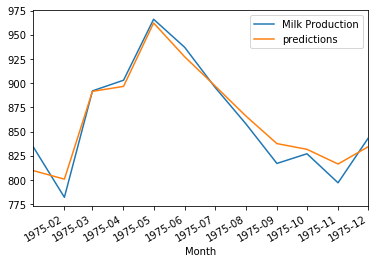

In [37]:
milk_test_df.plot()

Our predictions seem to follow a similar trend to our test set